# SPISEA Quick Start: Making A Cluster

This is a quick start guide to making a synthetic cluster using the SPISEA package. The cluster is constructed using a user-specified isochrone and initial mass function (IMF). Detailed documentation is provided in the ReadtheDocs page (https://pypopstar.readthedocs.io/en/latest/).

Before starting this tutorial, it is assumed that SPISEA has been installed and the user's python path has been altered to include the SPISEA top-level directory

In [1]:
# Import necessary packages. 
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

/Users/mwhosek/anaconda3/envs/astroconda2/lib/python3.6/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/mwhosek/models/models_2019_07/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


#### Step 1: Make a SPISEA isochrone object

The cluster is made from a theoretical isochrone at a given age, extinction, and distance from Earth. These parameters MUST be specified by the user. Other inputs (e.g. stellar evolution/atmosphere models, extinction law, and photometric filters used) are optional keywords. See documentation for all keywords and their default values.

Important Note: The IsochronePhot class saves its output as a FITS table, which it will read on subsequent calls for the same isochrone rather than regenerating it from scratch. We highly recommend reading the "Tips and Tricks: The IsochronePhot Object" section of the Isochrone object documentation for details on how this process works.

Here, we create a 5 Myr cluster isochrone at an extinction of 0.8 mags and distance of 4000 pc from Earth. 

In [2]:
# Define isochrone parameters
logAge = np.log10(5*10**6.) # Age in log(years)
AKs = 0.8 # extinction in mags
dist = 4000 # distance in parsec
metallicity = 0 # Metallicity in [M/H]

# Define evolution/atmosphere models and extinction law
evo_model = evolution.MISTv1() 
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()

# Also specify filters for synthetic photometry (optional). Here we use 
# the HST WFC3-IR F127M, F139M, and F153M filters
filt_list = ['wfc3,ir,f127m', 'wfc3,ir,f139m', 'wfc3,ir,f153m']

# Make Isochrone object. Note that is calculation will take a few minutes, unless the 
# isochrone has been generated previously.
my_iso = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=0,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list)

Once calculated, the isochrone will be written as a fits file to a location set by the "iso_dir" keyword (not shown here; default location is current working directory). In the future, the IsochronePhot function will read this file directly rather than recalculating the isochrone again. 

The file name will be the following: "iso_logAge_AKs_distance_metallicity.fits, using the specified values

In [3]:
# The individual points in the isochrone can be accessed using the points subfunction 
# on the isochrone object. This produces an astropy table that contains the 
# list of stellar masses in the isochrone and their associated properties
print(my_iso.points)

          L                   Teff        ...    m_hst_f153m    
          W                    K          ...                   
---------------------- ------------------ ... ------------------
 8.660109049222469e+24  2997.482453641835 ... 21.152021446472187
 9.046193280874383e+24 3008.7858260184175 ...  21.10504146351601
 9.449142476745298e+24 3020.1687795233192 ... 21.058402938590124
 9.869958611246552e+24  3031.631609685951 ... 21.011969614374383
 1.076707529684324e+25 3054.6500837349886 ... 20.919821469802322
1.0829426036763875e+25 3065.3879429582494 ... 20.915499755622307
1.1480726894593663e+25  3078.908328291189 ...  20.85389598461618
 1.221834686575575e+25  3093.002145149403 ... 20.788339065157267
1.3043887291289771e+25 3107.5858797888227 ... 20.717377389444135
1.3956010100862058e+25 3122.5861578385725 ...  20.64218049226777
                   ...                ... ...                ...
 3.146902975957394e+32 13997.739388490047 ...  5.930259429665395
3.1460717791216517e+32 13

In [4]:
# The isochrone table has meta keywords describing its properties
print(my_iso.points.meta)

OrderedDict([('REDLAW', 'H18b'), ('ATMFUNC', 'get_merged_atmosphere'), ('EVOMODEL', 'MISTv1'), ('LOGAGE', 6.698970004336019), ('AKS', 0.8), ('DISTANCE', 4000), ('METAL_IN', 0), ('METAL_ACT', 0.02380291467262473), ('WAVEMIN', 3000), ('WAVEMAX', 52000)])


In [5]:
print('The columns in the isochrone table are: {0}'.format(my_iso.points.keys()))

The columns in the isochrone table are: ['L', 'Teff', 'R', 'mass', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m']


In [6]:
# Identify a 1 M_sun star, print F127M, F139M, and F153M mags
idx = np.where( abs(my_iso.points['mass'] - 1.0) == min(abs(my_iso.points['mass'] - 1.0)) )[0]
f127m = np.round(my_iso.points[idx[0]]['m_hst_f127m'], decimals=3)
f139m = np.round(my_iso.points[idx[0]]['m_hst_f139m'], decimals=3)
f153m = np.round(my_iso.points[idx[0]]['m_hst_f153m'], decimals=3)
print('1 M_sun: F127M = {0} mag, F139M = {1} mag, F153M = {2} mag'.format(f127m, f139m, f153m))

1 M_sun: F127M = 19.047 mag, F139M = 18.446 mag, F153M = 17.773 mag


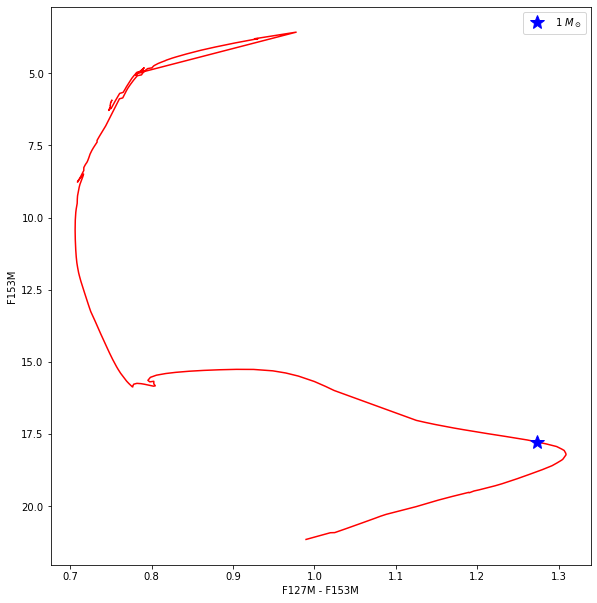

In [7]:
# Make a color-magnitude diagram
py.figure(1, figsize=(10,10))
py.clf()
py.plot(my_iso.points['m_hst_f127m'] - my_iso.points['m_hst_f153m'], 
       my_iso.points['m_hst_f153m'], 'r-', label='_nolegend_')
py.plot(my_iso.points['m_hst_f127m'][idx] - my_iso.points['m_hst_f153m'][idx], 
       my_iso.points['m_hst_f153m'][idx], 'b*', ms=15, label='1 $M_\odot$')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

### Step 2: Make an Initial Mass Function

PopStar offers a range of initial mass functions (IMFs) a user can use from to make the cluster. In addition to the parameters defining the IMF, the user can pass in a PopStar multiplicity object, which defines the multiplicity properties of the population. The default multiplicity is None (e.g. all stars are single).

Here we define a Kroupa IMF using the Multiplicity properties defined in Lu+13. 

In [8]:
# Make multiplicity object
imf_multi = multiplicity.MultiplicityUnresolved()

# Make IMF object; we'll use a broken power law with the parameters from Kroupa+01.

# NOTE: when defining the power law slope for each segment of the IMF, we define
# the entire exponent, including the negative sign. For example, if dN/dm $\propto$ m^-alpha,
# then you would use the value "-2.3" to specify an IMF with alpha = 2.3. 

massLimits = np.array([0.2, 0.5, 1, 120]) # Define boundaries of each mass segement
powers = np.array([-1.3, -2.3, -2.3]) # Power law slope associated with each mass segment
my_imf = imf.IMF_broken_powerlaw(massLimits, powers, imf_multi)

### Step 3: Make the Cluster  
#### Option 1: No compact objects
To create the cluster, the user passes in an isochrone object, and imf object, and specifies the total cluster mass. Here we will make a 10^5 M_sun cluster using the isochrone and imf we have defined.

The individual star systems in the cluster and their properties are stored in an astropy table accessed by the star_systems subfunction on the cluster object. Note that the photometry of these star systems includes the contributions from all companions, which are generated probabilistically using the multiplicity defined in the IMF object.

In [9]:
# Define total cluster mass
mass = 10**5.

# Make cluster object
cluster = synthetic.ResolvedCluster(my_iso, my_imf, mass)

# Look at star systems table
print(cluster.star_systems)

Found 69 stars out of mass range
        mass        isMultiple ...    m_hst_f153m     N_companions
------------------- ---------- ... ------------------ ------------
 0.3902825393188909      False ... 19.198675247781733            0
0.36442534730486614      False ... 19.299625963230316            0
 0.2960597619579401      False ... 19.622871173104592            0
  4.020275631753382       True ... 14.942859924256084            1
0.22535244432792711      False ...  20.04719216513875            0
 0.4337891871272154      False ... 19.043037175056032            0
 0.2550352762897599      False ...  19.84725853661653            0
 0.3886897076801539      False ... 19.204793244269553            0
 0.2207786288985551      False ...  20.07793050759004            0
 3.1627242881250925       True ... 15.435498104534354            1
                ...        ... ...                ...          ...
 2.0209398200626008      False ... 15.286966341315408            0
 0.5562568588776408      Fals

In [10]:
print('The cluster table contains these columns: {0}'.format(cluster.star_systems.keys()))

The cluster table contains these columns: ['mass', 'isMultiple', 'systemMass', 'Teff', 'L', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m', 'N_companions']


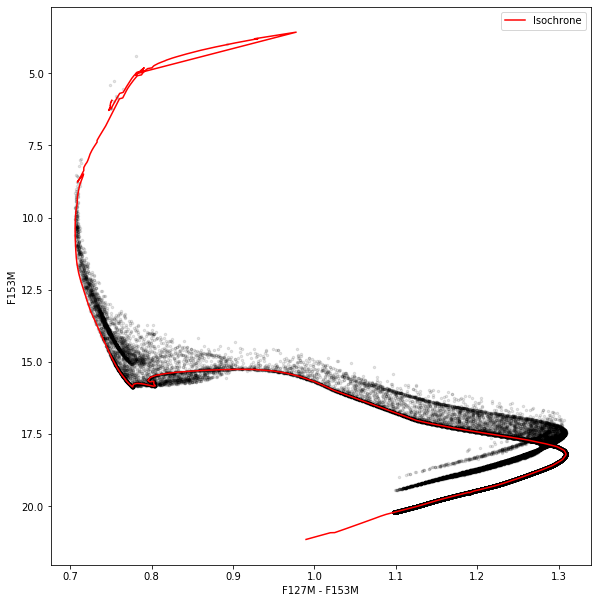

In [11]:
# Look at the cluster CMD, compared to input isochrone. Note the impact of
# multiple systems on the photometry
clust = cluster.star_systems
iso = my_iso.points

py.figure(2, figsize=(10,10))
py.clf()
py.plot(clust['m_hst_f127m'] - clust['m_hst_f153m'], clust['m_hst_f153m'],
       'k.', ms=5, alpha=0.1, label='__nolegend__')
py.plot(iso['m_hst_f127m'] - iso['m_hst_f153m'], iso['m_hst_f153m'],
       'r-', label='Isochrone')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

#### Option 2: Compact objects (white dwarfs, neutron stars, and black holes)
This is quite similar to the above, but includes compact objects. The additional piece of information required is to choose an initial-final mass relation (IFMR.) Currently there's only one choice in PopStar, so that makes your decision easy...

The output is the same as if we were making a cluster without using an IFMR. However, you can tell that compact objects are made by looking at the 'phase' keyword. Black holes have 'phase' = 103, neutron stars have 'phase' = 102, and white dwarfs have 'phase' = 101. For these compact objects, the luminosity and temperature will return values of zero, and photometry will return nan, since we are assuming they are totally dark.

Here, we make 4 different clusters, each of mass $10^6 M_\odot$, by taking different combinations of age (either 100 Myr or 10 Gyr) and IMF (top-heavy or Kroupa). We then look at the different distributions of BH and WD masses. (Since NSs are all assigned a single mass in the IFMR, the mass distribution there is not very interesting. However, the relative number of NSs for each cluster will be different.)

In [12]:
# Create isochrone object  
filt_list = ['wfc3,ir,f153m'] # We won't be doing much with synthetic photometry here, so only 1 filter
my_ifmr = ifmr.IFMR()
my_iso_young = synthetic.IsochronePhot(8, 0, 10,
                                 evo_model = evolution.MISTv1(),
                                      filters=filt_list)

my_iso_old = synthetic.IsochronePhot(10, 0, 10,
                                 evo_model = evolution.MISTv1(),
                                    filters=filt_list)
# Create IMF object                                                                                                                                                        
massLimits = np.array([0.1, 0.5, 120])
powers_kroupa = np.array([-1.3, -2.3])
powers_theavy = np.array([-1.3, -1.3]) # top heavy
trunc_kroupa = imf.IMF_broken_powerlaw(massLimits, powers_kroupa)
trunc_theavy = imf.IMF_broken_powerlaw(massLimits, powers_theavy)

# Make cluster                                                                                                                                                             
cluster_mass = 10**6
cluster_young_theavy = synthetic.ResolvedCluster(my_iso_young, trunc_theavy, cluster_mass, ifmr=my_ifmr)
cluster_old_theavy = synthetic.ResolvedCluster(my_iso_old, trunc_theavy, cluster_mass, ifmr=my_ifmr)
cluster_young_kroupa = synthetic.ResolvedCluster(my_iso_young, trunc_kroupa, cluster_mass, ifmr=my_ifmr)
cluster_old_kroupa = synthetic.ResolvedCluster(my_iso_old, trunc_kroupa, cluster_mass, ifmr=my_ifmr)

# Get the outputs
young_theavy = cluster_young_theavy.star_systems
old_theavy = cluster_old_theavy.star_systems
young_kroupa = cluster_young_kroupa.star_systems
old_kroupa = cluster_old_kroupa.star_systems

Found 5564 stars out of mass range
Found 4249 stars out of mass range
Found 100598 stars out of mass range
Found 74050 stars out of mass range


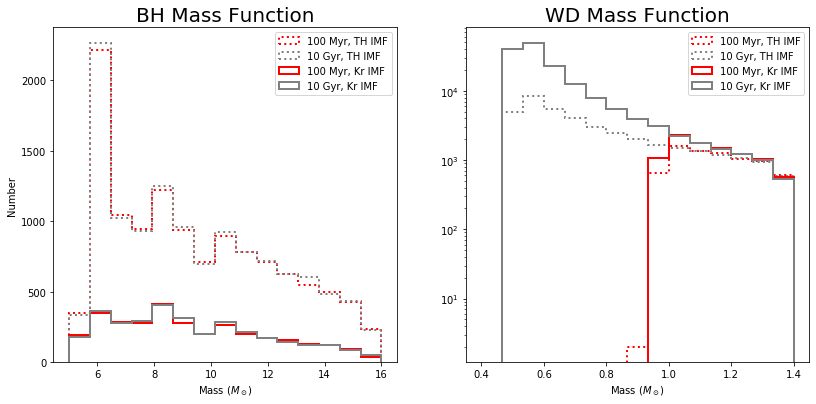

In [13]:
young_theavy_bh_idx = np.where(young_theavy['phase'] == 103)[0]
old_theavy_bh_idx = np.where(old_theavy['phase'] == 103)[0]
young_kroupa_bh_idx = np.where(young_kroupa['phase'] == 103)[0]
old_kroupa_bh_idx = np.where(old_kroupa['phase'] == 103)[0]

bh_bins = np.linspace(5, 16, 16)
wd_bins = np.linspace(0.4, 1.4, 16)

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.hist(young_theavy[young_theavy_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '100 Myr, TH IMF', color = 'red', linestyle = ':', lw = 2)
plt.hist(old_theavy[old_theavy_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '10 Gyr, TH IMF', color = 'gray', linestyle = ':', lw = 2)
plt.hist(young_kroupa[young_kroupa_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '100 Myr, Kr IMF', color = 'red', lw = 2)
plt.hist(old_kroupa[old_kroupa_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '10 Gyr, Kr IMF', color = 'gray', lw = 2)
plt.title('BH Mass Function')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

young_theavy_wd_idx = np.where(young_theavy['phase'] == 101)[0]
old_theavy_wd_idx = np.where(old_theavy['phase'] == 101)[0]
young_kroupa_wd_idx = np.where(young_kroupa['phase'] == 101)[0]
old_kroupa_wd_idx = np.where(old_kroupa['phase'] == 101)[0]

plt.subplot(1, 2, 2)
plt.hist(young_theavy[young_theavy_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '100 Myr, TH IMF', color = 'red', linestyle = ':', lw = 2)
plt.hist(old_theavy[old_theavy_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '10 Gyr, TH IMF', color = 'gray', linestyle = ':', lw = 2)
plt.hist(young_kroupa[young_kroupa_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '100 Myr, Kr IMF', color = 'red', lw = 2)
plt.hist(old_kroupa[old_kroupa_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '10 Gyr, Kr IMF', color = 'gray', lw = 2)
plt.yscale('log')
plt.title('WD Mass Function')
plt.xlabel('Mass ($M_\odot$)')
plt.legend()

Plotted above are the distributions of BH and WD masses for clusters of different ages (100 Myr or 10 Gyr), with either a top-heavy or Kroupa IMF. For BHs, since those are formed relatively early on, the age of the cluster does not significantly change the mass distribution as most BHs have already formed by 100 Myr. However, the top heavy IMF allows the creation of many more massive compact objects. For WDs, both the age and IMF make significant differences in the distribution (note y-axis is logscaled).